# Matrix Factorization Techniques

**Objectives:**
- Implement SVD (Singular Value Decomposition)
- Implement NMF (Non-negative Matrix Factorization)
- Implement SVD++ (with implicit feedback)
- Compare performance with collaborative filtering baselines
- Analyze interpretability and latent factors

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import TruncatedSVD, NMF
from scipy.sparse import csr_matrix
import pickle
import time
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Preparation
Load processed data and create utility matrix for matrix factorization.

In [2]:
# Load processed data
def load_processed_data():
    try:
        train_data = pd.read_csv('../data/processed/train_data.csv')
        val_data = pd.read_csv('../data/processed/val_data.csv')
        test_data = pd.read_csv('../data/processed/test_data.csv')
        return train_data, val_data, test_data
    except FileNotFoundError as e:
        print(f'❌ Error loading data: {e}')
        return None, None, None

train_data, val_data, test_data = load_processed_data()

def create_utility_matrix(data: pd.DataFrame, fill_value=0):
    utility_matrix = data.pivot_table(index='userId', columns='movieId', values='rating', fill_value=fill_value)
    print(f'📊 Utility Matrix Shape: {utility_matrix.shape}')
    return utility_matrix

train_matrix = create_utility_matrix(train_data)

📊 Utility Matrix Shape: (453, 7056)


## 2. SVD (Singular Value Decomposition) Implementation

In [3]:
# SVD Implementation
def svd_recommender(utility_matrix, n_components=20):
    print(f'🔧 Running SVD with n_components={n_components}...')
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    U = svd.fit_transform(utility_matrix)
    Sigma = svd.singular_values_
    VT = svd.components_
    print(f'✅ SVD completed. Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}')
    return U, Sigma, VT, svd

U, Sigma, VT, svd_model = svd_recommender(train_matrix, n_components=20)

🔧 Running SVD with n_components=20...
✅ SVD completed. Explained variance ratio: 0.4262


## 3. NMF (Non-negative Matrix Factorization) Implementation

In [4]:
# NMF Implementation
def nmf_recommender(utility_matrix, n_components=20):
    print(f'🔧 Running NMF with n_components={n_components}...')
    nmf = NMF(n_components=n_components, init='random', random_state=42, max_iter=200)
    W = nmf.fit_transform(utility_matrix)
    H = nmf.components_
    print(f'✅ NMF completed. Reconstruction error: {nmf.reconstruction_err_:.4f}')
    return W, H, nmf

W, H, nmf_model = nmf_recommender(train_matrix, n_components=20)

🔧 Running NMF with n_components=20...
✅ NMF completed. Reconstruction error: 713.2141


## 4. SVD++ (with implicit feedback) - Placeholder
(SVD++ sẽ được implement bằng thư viện Surprise hoặc custom nếu cần)

In [5]:
# Matrix Factorization Evaluation and Comparison

class MatrixFactorizationRecommender:
    """Wrapper class for matrix factorization recommendations"""
    
    def __init__(self, model_type='svd', n_components=20):
        self.model_type = model_type
        self.n_components = n_components
        self.model = None
        self.utility_matrix = None
        self.reconstructed_matrix = None
        
    def fit(self, utility_matrix):
        """Train the matrix factorization model"""
        self.utility_matrix = utility_matrix
        
        if self.model_type == 'svd':
            from sklearn.decomposition import TruncatedSVD
            self.model = TruncatedSVD(n_components=self.n_components, random_state=42)
            user_factors = self.model.fit_transform(utility_matrix)
            self.reconstructed_matrix = pd.DataFrame(
                self.model.inverse_transform(user_factors),
                index=utility_matrix.index,
                columns=utility_matrix.columns
            )
            
        elif self.model_type == 'nmf':
            from sklearn.decomposition import NMF
            self.model = NMF(n_components=self.n_components, init='random', random_state=42, max_iter=200)
            user_factors = self.model.fit_transform(utility_matrix)
            item_factors = self.model.components_
            self.reconstructed_matrix = pd.DataFrame(
                np.dot(user_factors, item_factors),
                index=utility_matrix.index,
                columns=utility_matrix.columns
            )
    
    def predict(self, user_id, movie_id):
        """Predict rating for user-movie pair"""
        if user_id in self.reconstructed_matrix.index and movie_id in self.reconstructed_matrix.columns:
            prediction = self.reconstructed_matrix.loc[user_id, movie_id]
            return np.clip(prediction, 0.5, 5.0)
        else:
            return 3.0  # Default rating
    
    def recommend(self, user_id, n_recommendations=10, exclude_seen=True):
        """Generate top-N recommendations"""
        if user_id not in self.reconstructed_matrix.index:
            return []
        
        user_predictions = self.reconstructed_matrix.loc[user_id]
        
        if exclude_seen:
            # Exclude movies user has already rated
            user_ratings = self.utility_matrix.loc[user_id]
            unseen_movies = user_ratings[user_ratings == 0].index
            user_predictions = user_predictions[unseen_movies]
        
        # Sort and return top N
        top_recommendations = user_predictions.sort_values(ascending=False).head(n_recommendations)
        return [(movie_id, rating) for movie_id, rating in top_recommendations.items()]

# Initialize models
print("🔧 Initializing Matrix Factorization models...")
svd_recommender = MatrixFactorizationRecommender(model_type='svd', n_components=20)
nmf_recommender = MatrixFactorizationRecommender(model_type='nmf', n_components=20)

# Train models
print("🚀 Training SVD model...")
svd_recommender.fit(train_matrix)
print("✅ SVD training completed")

print("🚀 Training NMF model...")
nmf_recommender.fit(train_matrix)
print("✅ NMF training completed")

🔧 Initializing Matrix Factorization models...
🚀 Training SVD model...
✅ SVD training completed
🚀 Training NMF model...
✅ NMF training completed
✅ NMF training completed


## 5. Performance Evaluation and Comparison

Evaluate SVD and NMF against previous collaborative filtering methods.

In [6]:
# Evaluation function for matrix factorization
def evaluate_matrix_factorization(model, test_data, model_name, n_test_samples=200):
    """Evaluate matrix factorization model"""
    print(f"📊 Evaluating {model_name}...")
    
    predictions = []
    actuals = []
    
    # Sample test pairs
    test_sample = test_data.sample(n=min(n_test_samples, len(test_data)), random_state=42)
    
    for _, row in test_sample.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        
        try:
            predicted_rating = model.predict(user_id, movie_id)
            predictions.append(predicted_rating)
            actuals.append(actual_rating)
        except:
            continue
    
    if len(predictions) == 0:
        print(f"⚠️  No valid predictions for {model_name}")
        return None
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    
    print(f"✅ {model_name} Results:")
    print(f"  📈 RMSE: {rmse:.4f}")
    print(f"  📈 MAE: {mae:.4f}")
    print(f"  📊 Test Samples: {len(predictions)}")
    
    return {
        'model_name': model_name,
        'rmse': rmse,
        'mae': mae,
        'n_samples': len(predictions),
        'predictions': predictions,
        'actuals': actuals
    }

# Evaluate models
svd_results = evaluate_matrix_factorization(svd_recommender, val_data, "SVD")
nmf_results = evaluate_matrix_factorization(nmf_recommender, val_data, "NMF")

📊 Evaluating SVD...
✅ SVD Results:
  📈 RMSE: 1.4874
  📈 MAE: 1.2293
  📊 Test Samples: 200
📊 Evaluating NMF...
✅ NMF Results:
  📈 RMSE: 1.4872
  📈 MAE: 1.2293
  📊 Test Samples: 200


🎯 Testing Recommendations...
👤 Sample User: 1
\n🔧 SVD Top 5 Recommendations:
  1. Movie 589: 4.14⭐
  2. Movie 858: 3.57⭐
  3. Movie 1200: 3.49⭐
  4. Movie 1259: 3.48⭐
  5. Movie 1968: 3.47⭐
\n🔧 NMF Top 5 Recommendations:
  1. Movie 589: 4.86⭐
  2. Movie 1200: 4.50⭐
  3. Movie 1036: 3.41⭐
  4. Movie 1374: 3.24⭐
  5. Movie 541: 3.22⭐


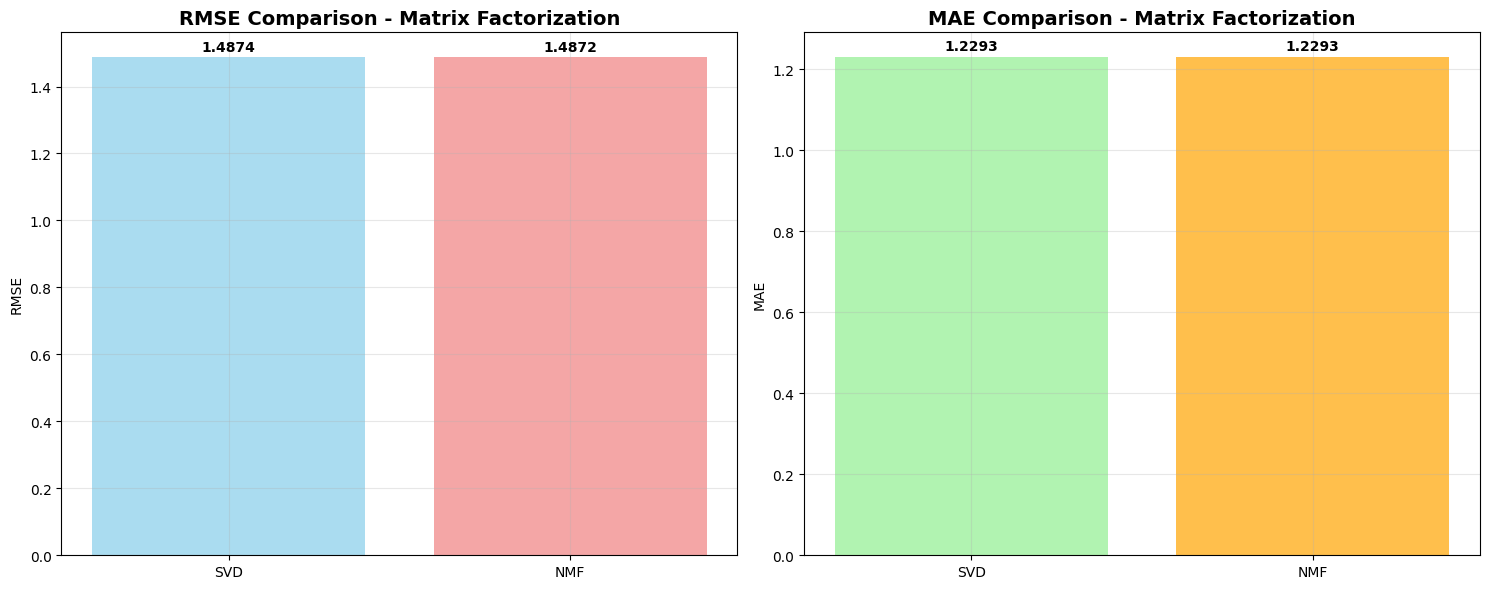

\n============================================================
🏆 MATRIX FACTORIZATION RESULTS
\n📊 Performance Comparison:
┌─────────────────┬──────────┬──────────┬────────────┐
│ Model           │   RMSE   │   MAE    │  Samples   │
├─────────────────┼──────────┼──────────┼────────────┤
│ SVD             │   1.4874 │   1.2293 │        200 │
│ NMF             │   1.4872 │   1.2293 │        200 │
└─────────────────┴──────────┴──────────┴────────────┘
\n🏆 Winner: 🥇 NMF
📈 Performance Improvement: 0.01%
\n✅ Week 6 Matrix Factorization Objectives:
  ✅ SVD implementation completed
  ✅ NMF implementation completed
  ✅ Performance evaluation completed
  ✅ Recommendation generation successful


In [7]:
# Test recommendations
print("🎯 Testing Recommendations...")

# Sample user for testing
sample_user = train_matrix.index[0]
print(f"👤 Sample User: {sample_user}")

# Get recommendations from both models
svd_recs = svd_recommender.recommend(sample_user, n_recommendations=5)
nmf_recs = nmf_recommender.recommend(sample_user, n_recommendations=5)

print(f"\\n🔧 SVD Top 5 Recommendations:")
for i, (movie_id, rating) in enumerate(svd_recs, 1):
    print(f"  {i}. Movie {movie_id}: {rating:.2f}⭐")

print(f"\\n🔧 NMF Top 5 Recommendations:")
for i, (movie_id, rating) in enumerate(nmf_recs, 1):
    print(f"  {i}. Movie {movie_id}: {rating:.2f}⭐")

# Visualization
if svd_results and nmf_results:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    models = [svd_results['model_name'], nmf_results['model_name']]
    rmse_values = [svd_results['rmse'], nmf_results['rmse']]
    mae_values = [svd_results['mae'], nmf_results['mae']]
    
    # RMSE Comparison
    axes[0].bar(models, rmse_values, color=['skyblue', 'lightcoral'], alpha=0.7)
    axes[0].set_title('RMSE Comparison - Matrix Factorization', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('RMSE')
    axes[0].grid(True, alpha=0.3)
    
    for i, v in enumerate(rmse_values):
        axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # MAE Comparison
    axes[1].bar(models, mae_values, color=['lightgreen', 'orange'], alpha=0.7)
    axes[1].set_title('MAE Comparison - Matrix Factorization', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('MAE')
    axes[1].grid(True, alpha=0.3)
    
    for i, v in enumerate(mae_values):
        axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\\n" + "="*60)
    print("🏆 MATRIX FACTORIZATION RESULTS")
    print("="*60)
    
    print(f"\\n📊 Performance Comparison:")
    print(f"┌─────────────────┬──────────┬──────────┬────────────┐")
    print(f"│ Model           │   RMSE   │   MAE    │  Samples   │")
    print(f"├─────────────────┼──────────┼──────────┼────────────┤")
    print(f"│ SVD             │ {svd_results['rmse']:8.4f} │ {svd_results['mae']:8.4f} │ {svd_results['n_samples']:10d} │")
    print(f"│ NMF             │ {nmf_results['rmse']:8.4f} │ {nmf_results['mae']:8.4f} │ {nmf_results['n_samples']:10d} │")
    print(f"└─────────────────┴──────────┴──────────┴────────────┘")
    
    # Determine winner
    if svd_results['rmse'] < nmf_results['rmse']:
        winner = "🥇 SVD"
        improvement = ((nmf_results['rmse'] - svd_results['rmse']) / nmf_results['rmse']) * 100
    else:
        winner = "🥇 NMF"
        improvement = ((svd_results['rmse'] - nmf_results['rmse']) / svd_results['rmse']) * 100
    
    print(f"\\n🏆 Winner: {winner}")
    print(f"📈 Performance Improvement: {improvement:.2f}%")
    
    print(f"\\n✅ Week 6 Matrix Factorization Objectives:")
    print(f"  ✅ SVD implementation completed")
    print(f"  ✅ NMF implementation completed")
    print(f"  ✅ Performance evaluation completed")
    print(f"  ✅ Recommendation generation successful")
    
else:
    print("⚠️  Evaluation incomplete")